# 基于 Seq2Seq 模型的机器翻译实践

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from datasets import load_dataset

# Step1: 加载数据集，并进行数据预处理

## 1.1 加载本地数据集

使用 huggingface 的 datasets 库来加载一个 huggingface 上的数据集（本数据集已经下载到本地）。并划分训练集与数据集。

使用的是HuggingFace dataset 中的一个中英翻译的一个数据集：[Garsa3112/ChineseEnglishTranslationDataset](https://huggingface.co/datasets/Garsa3112/ChineseEnglishTranslationDataset)

In [2]:
translation_data = load_dataset(
    "arrow",
    data_files={
        "train": "/data/datasets/Garsa3112/ChineseEnglishTranslationDataset/train.arrow"
    },
    split="train",
)

num_samples = len(translation_data)

# 划分训练和测试数据集，测试集占20%
train_test_data = translation_data.train_test_split(test_size=0.1)

# 将数据集的随机10条记录转换为DataFrame并展示
sample_idx = np.random.randint(0, num_samples, 10)
sample_df = pd.DataFrame(translation_data.select(sample_idx))
sample_df.head()

,en,zh
0,They decide to go to Kashmir for their honeymo...,"随后他们前往日本度蜜月,而迪马乔正好也有出差。"
1,Kester Echenim.,Calender 砑光。
2,"A luxury car, taxi, or passenger bus would be ...",高级房车、计程车或客运巴士通常可以说是具备较软的弹簧。
3,At the Third Congress of Austrian Socialists h...,"在奥地利社会主义者第三次代表大会上,达申斯基坚持要将波兰社会民主党与奥地利组织分离,并强调了..."
4,Promoting Content in Africa Keynote.,单曲封面主题为非洲。


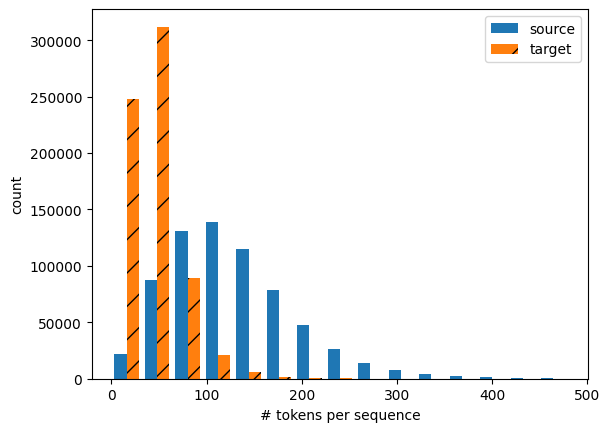

In [3]:
text_length = [(len(sample["en"]), len(sample["zh"])) for sample in translation_data]
src_seq_length, tgt_seq_length = zip(*text_length)

bins = np.arange(0, 512, 32)
_, _, patches = plt.hist(
    [src_seq_length, tgt_seq_length],
    bins=bins,
)
plt.xlabel("# tokens per sequence")
plt.ylabel("count")
for patch in patches[1].patches:
    patch.set_hatch("/")
plt.legend(["source", "target"])

plt.show()

## 1.2 创建分词器，并创建 Dataloader

通过自定义的 collate function 来对翻译的源文本与目标文本分别进行分词并转换为 token ids

In [4]:
from functools import partial


def collate_fn(batch_example, tokenizer, src_max_length, tgt_max_length):
    src_texts = []
    tgt_texts = []
    for example in batch_example:
        src_texts.append(example["en"])
        tgt_texts.append(tokenizer.bos_token + example["zh"] + tokenizer.eos_token)
    src_tokenized = tokenizer(
        src_texts,
        padding="longest",
        max_length=src_max_length,
        truncation=True,
        return_tensors="pt",
        add_special_tokens=False,
    )
    tgt_tokenized = tokenizer(
        tgt_texts,
        padding="longest",
        max_length=tgt_max_length,
        truncation=True,
        return_tensors="pt",
        add_special_tokens=False,
    )
    return {
        "src_input_ids": src_tokenized.input_ids,
        "src_attention_mask": src_tokenized.attention_mask,
        "tgt_input_ids": tgt_tokenized.input_ids[:, :-1],
        "tgt_attention_mask": tgt_tokenized.attention_mask[:, :-1],
        "labels": tgt_tokenized.input_ids[:, 1:],
    }


tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-macbert-base")
tokenizer.add_special_tokens(
    {
        "bos_token": "[BOS]",
        "eos_token": "[EOS]",
    }
)

batch_size = 32
src_max_length = 384
tgt_max_length = 256

train_dataloader = DataLoader(
    train_test_data["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=partial(
        collate_fn,
        tokenizer=tokenizer,
        src_max_length=src_max_length,
        tgt_max_length=tgt_max_length,
    ),
)

validation_dataloader = DataLoader(
    train_test_data["test"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=partial(
        collate_fn,
        tokenizer=tokenizer,
        src_max_length=src_max_length,
        tgt_max_length=tgt_max_length,
    ),
)

# 2. 创建模型

In [5]:
def create_positional_embedding(max_len=256, embed_dim=512):
    """
    生成位置嵌入矩阵，用于为输入序列添加位置信息。

    参数:
    - max_len: 序列的最大长度
    - embed_dim: 嵌入向量的维度

    返回:
    - position_embeddings: 位置嵌入矩阵
    """
    position_indices = torch.arange(max_len)[:, None]
    div_term = torch.pow(10000, torch.arange(0, embed_dim, 2) / embed_dim)[None, :]
    position_embeddings = torch.zeros(max_len, embed_dim)
    position_embeddings[:, 0::2] = torch.sin(position_indices / div_term)
    position_embeddings[:, 1::2] = torch.cos(position_indices / div_term)

    return position_embeddings


def create_causal_mask(seq_len):
    """
    生成自回归掩码，用于避免在解码过程中看到未来的时间步。

    参数:
    - seq_len: 序列的长度

    返回:
    - causal_mask: 自回归掩码
    """
    return torch.triu(torch.ones(seq_len, seq_len), diagonal=1) == 1


class TransformerModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        max_seq_len,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        device,
    ):
        """
        初始化Transformer模型，用于序列到序列的翻译任务。

        参数:
        - vocab_size: 词汇表大小
        - max_seq_len: 最大序列长度
        - d_model: 嵌入维度
        - nhead: 多头注意力机制的头数
        - num_encoder_layers: 编码器层数
        - num_decoder_layers: 解码器层数
        - dim_feedforward: 前馈网络的维度
        - device: 运行设备
        """
        super().__init__()

        # 词嵌入层
        self.token_embedding = nn.Embedding(vocab_size, d_model, device=device)

        # 位置嵌入矩阵
        self.positional_embedding = create_positional_embedding(
            max_seq_len, d_model
        ).to(device=device)

        # 编码器层和编码器
        encoder_layer = nn.TransformerEncoderLayer(
            d_model,
            nhead,
            dim_feedforward,
            batch_first=True,
            norm_first=True,
            device=device,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer, num_encoder_layers, enable_nested_tensor=False
        )

        # 解码器层和解码器
        decoder_layer = nn.TransformerDecoderLayer(
            d_model,
            nhead,
            dim_feedforward,
            batch_first=True,
            norm_first=True,
            device=device,
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers)

        # 线性投影层，用于生成词汇表中的概率分布
        self.output_projection = nn.Linear(d_model, vocab_size, device=device)

    def forward(self, src, tgt, src_attention_mask, tgt_attention_mask):
        """
        执行前向传播，计算模型输出。

        参数:
        - src: 源序列
        - tgt: 目标序列
        - src_attention_mask: 源序列的掩码
        - tgt_attention_mask: 目标序列的掩码

        返回:
        - output_logits: 预测的词汇分布
        """
        src_embed = self.token_embedding(src)
        batch_size, src_len = src.shape

        # 为源序列添加位置嵌入
        src_positions = torch.arange(0, src_len)[None, :].repeat(batch_size, 1)
        src_embed += self.positional_embedding[src_positions]

        # 源序列的掩码
        src_key_padding_mask = src_attention_mask == 0
        memory = self.encoder(src_embed, src_key_padding_mask=src_key_padding_mask)

        # 生成目标序列的嵌入
        tgt_len = tgt.size(1)
        tgt_embed = self.token_embedding(tgt)
        tgt_positions = torch.arange(0, tgt_len)[None, :].repeat(batch_size, 1)
        tgt_embed += self.positional_embedding[tgt_positions]

        tgt_key_padding_mask = tgt_attention_mask == 0
        causal_mask = create_causal_mask(tgt_len).to(device=tgt.device)

        # 解码器的输出
        decoder_output = self.decoder(
            tgt_embed,
            memory,
            memory_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            tgt_is_causal=True,
            tgt_mask=causal_mask,
        )

        # 通过线性层得到词汇分布
        output_logits = self.output_projection(decoder_output)

        return output_logits

    def predict(self, src_text, tokenizer):
        with torch.inference_mode():
            pass

In [6]:
d_model = 512
nhead = 8
dim_feedforward = 2048
num_encoder_layers = 3
num_decoder_layers = 3
device = torch.device("cuda", 0)
vocab_size = len(tokenizer)

model = TransformerModel(
    vocab_size,
    max(src_max_length, tgt_max_length),
    d_model,
    nhead,
    num_encoder_layers,
    num_decoder_layers,
    dim_feedforward,
    device,
)

In [7]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # 设置模型为评估模式
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # 关闭梯度计算
        for batch in dataloader:
            # 获取输入和目标数据
            src_input = batch["src_input_ids"].to(device)
            src_mask = batch["src_attention_mask"].to(device)
            tgt_input = batch["tgt_input_ids"].to(device)
            tgt_mask = batch["tgt_attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # 前向传播
            logits = model(src_input, tgt_input, src_mask, tgt_mask).transpose(1, 2)

            # 计算损失
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # 计算准确率
            predicted_labels = torch.argmax(logits, dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [8]:
import logging

# 设置日志记录器
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

# 优化器和调度器
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# 训练参数
num_epochs = 3
n_steps = 0
log_interval = 100
eval_interval = 2000
grad_clip_value = 1.0  # 梯度裁剪阈值

for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    for batch in train_dataloader:
        # 将输入和目标数据迁移到设备
        src = batch["src_input_ids"].to(device)
        src_attention_mask = batch["src_attention_mask"].to(device)
        tgt = batch["tgt_input_ids"].to(device)
        tgt_attention_mask = batch["tgt_attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # 向前传播
        logits = model(src, tgt, src_attention_mask, tgt_attention_mask).transpose(1, 2)

        # 计算损失
        loss = criterion(logits, labels)

        # 反向传播和梯度更新
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)  # 梯度裁剪
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        n_steps += 1

        if n_steps % log_interval == 0:
            logging.info(
                f"Epoch: {epoch + 1}/{num_epochs}, Step: {n_steps}, Loss: {loss.item():.4f}"
            )
        if n_steps % eval_interval == 0:
            val_loss, val_accuracy = evaluate_model(
                model, validation_dataloader, criterion, device
            )
            logging.info(
                f"Validation - Epoch: {epoch + 1}, Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}"
            )

2024-09-16 23:25:38,196 - Epoch: 1/3, Step: 100, Loss: 1.3511
2024-09-16 23:26:24,996 - Epoch: 1/3, Step: 200, Loss: 3.1644
2024-09-16 23:27:15,324 - Epoch: 1/3, Step: 300, Loss: 1.9691
2024-09-16 23:28:03,420 - Epoch: 1/3, Step: 400, Loss: 2.3189
2024-09-16 23:28:53,813 - Epoch: 1/3, Step: 500, Loss: 2.6493
2024-09-16 23:29:44,081 - Epoch: 1/3, Step: 600, Loss: 2.2011
2024-09-16 23:30:33,847 - Epoch: 1/3, Step: 700, Loss: 2.3287
2024-09-16 23:31:23,609 - Epoch: 1/3, Step: 800, Loss: 2.1225
2024-09-16 23:32:12,119 - Epoch: 1/3, Step: 900, Loss: 2.2073
2024-09-16 23:32:59,787 - Epoch: 1/3, Step: 1000, Loss: 2.1682
2024-09-16 23:33:52,522 - Epoch: 1/3, Step: 1100, Loss: 1.9106
2024-09-16 23:34:41,512 - Epoch: 1/3, Step: 1200, Loss: 2.4593
2024-09-16 23:35:31,002 - Epoch: 1/3, Step: 1300, Loss: 1.8154
2024-09-16 23:36:20,439 - Epoch: 1/3, Step: 1400, Loss: 2.0338
2024-09-16 23:37:10,769 - Epoch: 1/3, Step: 1500, Loss: 2.2787
2024-09-16 23:38:03,683 - Epoch: 1/3, Step: 1600, Loss: 1.5839
2